<a href="https://colab.research.google.com/github/leolorenzoii/ml2_interpretability/blob/main/notebooks/03_Other_Model_Interpretation_Methods.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" align="left" alt="Open In Colab"/>
</a>

In [1]:
# # Run this cell if using Google Colab, then restart your kernel
# !pip install -r https://raw.githubusercontent.com/leolorenzoii/ml2_interpretability/main/requirements.txt

# Other Model Interpretation Methods

We have discussed in the previous notebooks the importance of model interpretability and focused our discussion on **SHAP (SHapley Additive exPlanations)**, one of the more popular methods for explaining model predictions. In this notebook, we broaden our perspective and discuss other readily available explanation methodologies.

Our discussion will focus mainly on **model-agnostic methods** and thus, they can be used to explain any black box models (see [Table 1](#table:other-methods)). We first give a brief big picture description and theory of the methods then proceed to show how they are implemented using readily available packages. Finally, we enumerate the advantages and disadvantages of each method.

<a name='table:other-methods'></a>
<div>
    <p style="font-size:12px;font-style:default;text-align: center">
        <b>Table 1.</b> Other model-agnostic explanation methods we will discuss and their corresponding classification.<br>
    </p>
</div>

| Method | Scope | Surrogate? |
| ------ | ----- | ---------- |
| Partial Dependence Plot (PDP) | Global 🌎 | ❌ |
| Individual Conditional Expectation (ICE) | Local 🚩 | ❌ |
| Permutation Importance | Global 🌎 | ❌ |
| Local Interpretable Model-agnostic Explanations | Local 🚩 | ✅ |

## Partial Dependence Plot

**Partial Dependence Plots (PDP)** helps us understand the effect a particular set of **features of interest** have on the **model outcome** that we're seeing and the **type of relationship** between the features and targets (or labels) in the data. It works by *marginalizing* over the values of all the other input features, which we call the **complement features**. We can interpret the partial dependence as the expected target response as a function of the input features [[1]](#ref:sklearn-pdp).

### Theory

#### Mathematical Definition

Suppose we have $X_S$ as our features of interest, and $X_C$ be the complement features. The partial dependence function at feature values $x_s$ in $X_S$ defined as the expected response of a model $f$ marginalized across the possible values of $X_C$:

$$
PDP_{X_S}(x_s) = \mathbb{E}_{X_C}[f(x_S, X_C)]\tag{1}
$$

Recall that expectation value can be written in probability form as:

$$
PDP_{X_S}(x_s) = \int f(x_S, x_C) p(x_C) dx_C \tag{2} \label{eq:pdp-def}
$$

For both equation, $f(x_S, x_C)$ refers to the model response or model outcome for feature values $x_s$ in the chosen features of interest $X_S$ and $x_C$ in the chosen complement features $X_C$. $p(x_C)$ refers to the probability that a feature value $x_C$ occurs.

#### Approximation methods

To calculate the exact PDP from the mathematical definition (see [Equation 2](#mjx-eqn-eq%3Apdp-def)), we need to know the probability distribution of $X_C$, $p(X_C)$. In practice it is difficult to get the exact or correct value for $p(X_C)$, as such, we usually perform *approximation methods* to compute for $PDP$.

One approximation in computing the PDP is the ***Monte Carlo*** method or ***brute*** method:

$$
PDP_{X_S}(x_S) \approx \frac{1}{n} \sum_{i=1}^n f \left( x_S, x_{C}^{(i)} \right)\tag{3} \label{eq:monte-carlo}
$$

Here, we approximate the integral by aggregating over the available dataset. As such, $n$ here is the number of samples in our dataset, and $x_{C}^{(i)}$ is the value of the $i$-th sample for the features in $X_C$. This method can be applied to any machine learning model, however, since it needs to make a full pass over the whole dataset for each possible values of $x_S$, this method can be *computationally intensive*.

Another method called the ***recursion*** method, *exclusively for tree-based models*, is much faster than the brute method. The recursion method traverses the trained tree-model for a given point $x_S$. The traversal rule is as follows:

1. If a split node involves a feature of interest, the corresponding left or right branch is followed.
2. Otherwise, both branches are followed and each branch will be weightd according to the fraction of training examples that entered that branch.
3. The partial dependence is given by the weighted average of all the visited leaves values.

### Implementation

Now let's implement Partial Dependence Plots in code!

We will use the UCI Bike Sharing (hourly) dataset in our analysis. Recall that the features of the dataset is as follows:

1. `dteday`: Date
2. `season`: Season (1:winter, 2:spring, 3:summer, 4:fall)
3. `yr`: Year (0: 2011, 1:2012)
4. `mnth`: Month ( 1 to 12)
5. `hr`: Hour (0 to 23)
6. `holiday`: Wether day is holiday or not (extracted from [Web Link])
7. `weekday`: Day of the week
8. `workingday`: If day is neither weekend nor holiday is 1, otherwise is 0.
9. `weathersit`: Weather situation
    - `1`: Clear, Few clouds, Partly cloudy, Partly cloudy
    - `2`: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - `3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - `4`: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
10. `temp`: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
11. `atemp`: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
12. `hum`: Normalized humidity. The values are divided to 100 (max)
13. `windspeed`: Normalized wind speed. The values are divided to 67 (max)
14. `casual`: count of casual users
15. `registered`: count of registered users
16. `cnt`: count of total rental bikes including both casual and registered

First, we import some libraries required by our analysis and set preambles for prettification of our plots.

In [2]:
# Import required libraries
import warnings

import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(1337)

# Some preambles for prettification
warnings.filterwarnings('ignore')
rcParams.update({'figure.figsize': (8, 6), 'axes.spines.top': False,
                 'axes.spines.right': False, 'axes.labelsize': 14,
                 'axes.titlesize': 16, 'axes.titleweight': 'bold',
                 'lines.linewidth': 3})

#### Data Preparation

We will load a preprocessed dataset which contains all the features with categorical features one-hot encoded accordingly.

In [3]:
data = pd.read_csv('../data/bike_sharing_hourly_processed.csv')
# # Use this line instead if using colab
# data = pd.read_csv('https://raw.githubusercontent.com/leolorenzoii/ml2_interpretability/main/data/bike_sharing_hourly_processed.csv')

All in all, our analytical base table has `17379` rows comprising of `57` features.

In [4]:
data

,yr,holiday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,1,0.24,0.2879,0.81,0.0000,3,13,16,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0.22,0.2727,0.80,0.0000,8,32,40,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0.22,0.2727,0.80,0.0000,5,27,32,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0.24,0.2879,0.75,0.0000,3,10,13,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0.24,0.2879,0.75,0.0000,0,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,2,0.26,0.2576,0.60,0.1642,11,108,119,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,2,0.26,0.2576,0.60,0.1642,8,81,89,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,1,0.26,0.2576,0.60,0.1642,7,83,90,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,1,0.26,0.2727,0.56,0.1343,13,48,61,...,0,1,0,0,1,0,0,0,0,0


#### Data Segregation

Afterwards, we set the test dataset to be the last 21 days of the dataset.

In [5]:
# Set days after the given `days` as test dataset
days = 21

# Set training and test dataset
training_dataset = data.iloc[:-days * 24, :]
test_dataset = data.iloc[-days * 24:, :]

Next, drop the target columns and highly correlated features from the predictors, then we choose the `cnt` as our target column.

In [6]:
# Drop these columns from the training dataset
drop_columns = ['cnt', 'casual', 'registered', 'temp', 'weathersit']

# Drop target columns, then use only `cnt`
train_predictors = training_dataset.drop(drop_columns, axis=1)
test_predictors = test_dataset.drop(drop_columns, axis=1)
train_targets = training_dataset.loc[:, 'cnt']
test_targets = test_dataset.loc[:, 'cnt']
feature_names = train_predictors.columns

#### Model Training

From our prior tuning, we found that Gradient Boosting Regressor with `max_depth` `8` is the optimal model for this problem.

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(max_depth=8, random_state=1337)
model.fit(train_predictors, train_targets)

GradientBoostingRegressor(max_depth=8, random_state=1337)

#### Model Testing

$R^2$ of this model is `0.8075`

In [8]:
model.score(test_predictors, test_targets)

0.7741468425445439

#### Model Interpretability

Now, let's interpret the model outcome using methods that we know and later on using **Partial Dependence Plots**. Since we used Gradient Boosting Regressor, which is a form of a tree model, we can retrieve its feature importance.

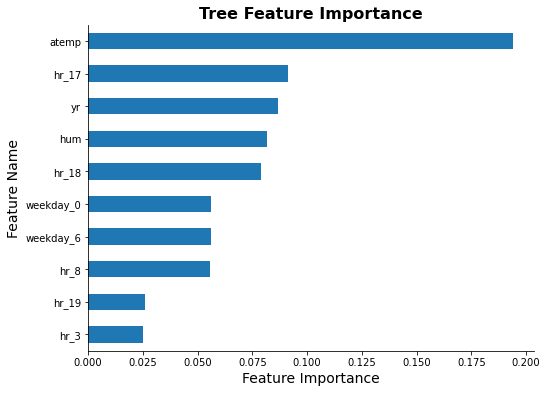

In [9]:
ax = (pd.Series(model.feature_importances_, index=feature_names)
        .sort_values(ascending=False).head(10).sort_values()
        .plot(kind='barh'))

ax.set_xlabel("Feature Importance")
ax.set_ylabel("Feature Name")
ax.set_title("Tree Feature Importance");

Here, we can see that the most important feature here is `atemp`, followed by categorical variables `hr_17` and `yr`. We can further extend our insights by plotting the Partial Dependence plot of the model.

For simplicity, we choose the top numerical features we found above as features of interest: feeling temperature `atemp` and humidity `hum`.

In generating the partial dependence plot, we only need the `PartialDependenceDisplay`, however, if we want the raw partial dependence values to create more customized plots, we must use the `partial_dependence` function.

In [10]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

##### Using the test dataset as reference

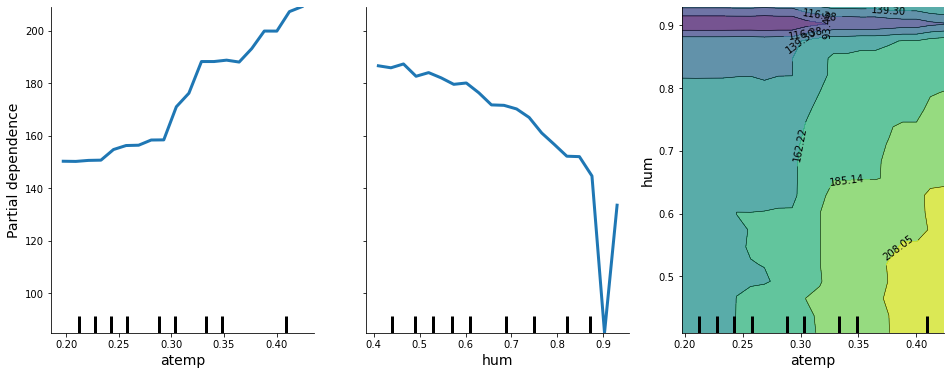

In [11]:
 # Define features to include in the plots
# This can be a single feature, or a combination of features, given as a tuple
features = ['atemp', 'hum', ('atemp', 'hum')]

# Intialize figure to be used in plotting
fig, ax = plt.subplots(figsize=(16, 6))

# Generate the partial dependence plot using
# PartialDependenceDisplay.from_estimator method
display = PartialDependenceDisplay.from_estimator(
    estimator=model,             # Estimator to be used
    X=test_predictors,           # Data to be used for interpretation
    features=features,           # Feature list to be inspected
    feature_names=feature_names, # Feature names in the data
    kind="average",              # kind='average' refers to PDP
    n_jobs=3,                    # Number of CPU to compute the PDP in parallel
    grid_resolution=20,          # Number of points to be used in setting the
                                 #     feature of interest
    random_state=1337,           # Set random state for reproducibility
    method='brute',              # Choose method of computing PDP
    ax=ax,  
)

##### Using the train dataset as reference

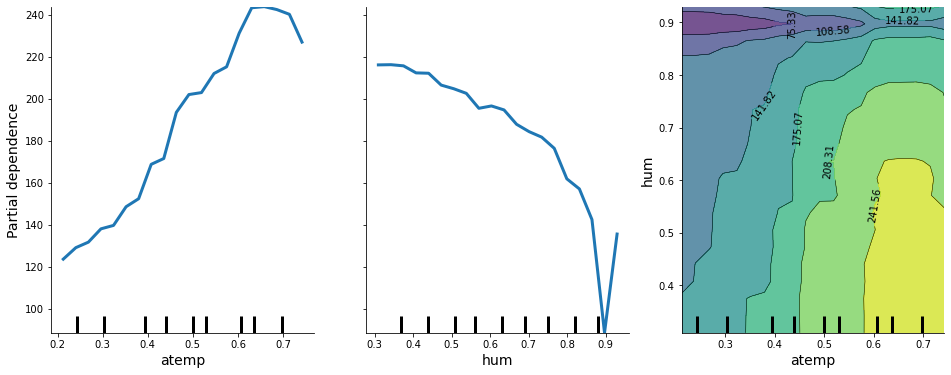

In [12]:
 # Define features to include in the plots
# This can be a single feature, or a combination of features, given as a tuple
features = ['atemp', 'hum', ('atemp', 'hum')]

# Intialize figure to be used in plotting
fig, ax = plt.subplots(figsize=(16, 6))

# Generate the partial dependence plot using
# PartialDependenceDisplay.from_estimator method
display = PartialDependenceDisplay.from_estimator(
    estimator=model,             # Estimator to be used
    X=train_predictors,          # Data to be used for interpretation
    features=features,           # Feature list to be inspected
    feature_names=feature_names, # Feature names in the data
    kind="average",              # kind='average' refers to PDP
    n_jobs=3,                    # Number of CPU to compute the PDP in parallel
    grid_resolution=20,          # Number of points to be used in setting the
                                 #     feature of interest
    random_state=1337,           # Set random state for reproducibility
    method='brute',              # Choose method for computing PDP
    ax=ax,  
)

Humidity has a clear **negative correlation** with the number of bike counts. When humidity is low number of bike counts increases, while high humidy results in lower rented bikes. Interpreting the `atemp` or feeling temperature is quite tricky. First, if we use only the *test dataset*, we notice that it's overall effect on the prediction is to decrease the bike counts whatever its value are. However, if we use the train dataset as our reference dataset, we notice that there is a range of temperature where the bike counts increases, then it starts to decrease again. This might be due to the fact that the feature values in the test dataset is *incomplete*.

When we look at the interaction between `atemp` and `hum`, we see that in both cases (whether we use the train or test dataset as reference), we have low bike counts when the humidity is high and the feeling temperature is low. then, we have high bike counts when the feeling temperature is high and humidity is relatively moderate.

*For reference `atemp=0.20` corresponds to `-2.80 °C`, `atemp=0.40` corresponds to `10.4 °C`, and `atemp=0.70` corresponds to `30.1 °C`.*

##### 3D interaction plots

Contour plots are essentially plots consisting of three-dimensions plotted on a 2D plane, hence we can actually get more fancy with our interaction plots and render a 3D plot for the same visualization. Follow the code below to do as such.

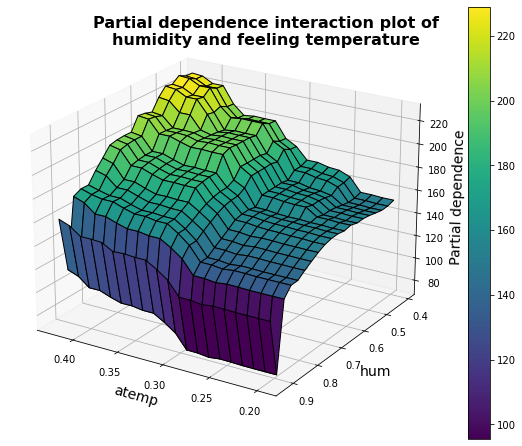

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Set features of interest
features = ("atemp", "hum")

# Compute for partial dependence plot
pdp = partial_dependence(
    model, test_predictors, features=features, kind="average",
    grid_resolution=20, method='brute'
)

# Create meshgrid for the 3d contour plot. `pdp` contains the pdp values
# 20 x 20 values since we selected the grid resolution to be `20`.
# This meshgrid arranges the points so that the corresponding points for
# the `hum` and `atemp` parameter matches with the corresponding pdp
# value
X_mesh, Y_mesh = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T

# Initialize 3D plot
fig = plt.figure()
ax = Axes3D(fig)
fig.add_axes(ax)

# Plot the 3d countour points as a surface plot
surf = ax.plot_surface(
    X_mesh, Y_mesh, Z, rstride=1, cstride=1, cmap='viridis',
    edgecolor="black")

# Set axis labels
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
plt.suptitle(
    "Partial dependence interaction plot of\nhumidity and feeling temperature",
    fontsize=16, weight='bold'
)
plt.subplots_adjust(top=0.9)

# Initialize view, set color bar then show
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.show()

### Advantage and Disadvantage

Now that we know how to implement partial dependence plots, let us enumerate its advantages and disadvantages [[2]](#ref:molnar).

#### Advantages

First and foremost advantage of Partial Dependence plot is that its theory is **easy to understand**. The PDP at a particular feature value represents the average prediction if we force all feature of interest at some value.

Next, if the features are uncorrelated, then the PDP represent how the feature influence the prediction on average. This makes **interpretation very clear** and straightforward. Note that for features with some degree of correlation, computation of PDP may lead to unintuitive propositions.

We can also make a **causal interpretation** using PDP. Note that during computation, what happens is we see how the prediction change when we change the feature value. As such, we analyzed effectively the causal relationship between the feature and prediction.

Finally, as we saw earlier, PDP is **straightforward to implement**.

#### Disadvantages

One disadvantage of **PDP** is that it **assumes that features are independent** with each other. During computation, notice that we need to create a grid of values, and if one of the feature of interest is actually correlated with the complement features, some grid values would result to unrealistic values.

Next, the **realistic number of features** we can inspect in the partial dependence function is two. This is because in the end, a human will inspect the PDP, hence, can only imagine up to 2 to 3 variables.

**Some PDP do not show the feature distribution.** Omitting this can be misleading, specially for data points with outliers. This can be mitigated by showing a rug (indicators for percentiles along the x-axis) or a histogram.

If we only use the PDP plots, we might miss on **heterogeneous effects**. This happens since we only take the average value of the model outcome for each feature value. How the model prediction behaves outside average is not reflected in the PDP plot.

<div class="alert alert-info">

**Point for Discussion**
    
In this implementation, we inspected numerical features. What will be the difference in the interpretation if we set *categorical variables* as our features of interest?

</div>

## ICE

**Individual Conditional Expectation (ICE)** is the local equivalent of PDP. Similar to PDP, it shows the dependence between the target function and an input feature of interest. However, ICE, instead visualizes the dependence of the prediction for each sample separately into one line per sample [[1]](#ref:sklearn-pdp).

The significance of looking at ICE plots instead of just looking at PDP is that PDP can obscure heterogenous relationships created by interactions of the chosen features of interest. PDP only shows you this as an average. ICE can give you more insight as to how the partial dependence vary on specific feature values of the chosen features of interest.

### Theory

The basis for the mathematical definition of ICE is similar to [Equation 3](#mjx-eqn-eq%3Amonte-carlo). However, this time, we first select a specific instance $i$ that we want to inspect, then fix the complement feature values $x_C^{(i)}$, while collecting the model prediction $f(x_S, x_C^{(i)})$ across all the grid values of $x_S$.

### Implementation

**ICE** plots can be readily plotted using the same `PartialDependenceDisplay` plotter which we used earlier. Here, we just have to change the parameter `kind` to `both` then set other parameters according to our liking.

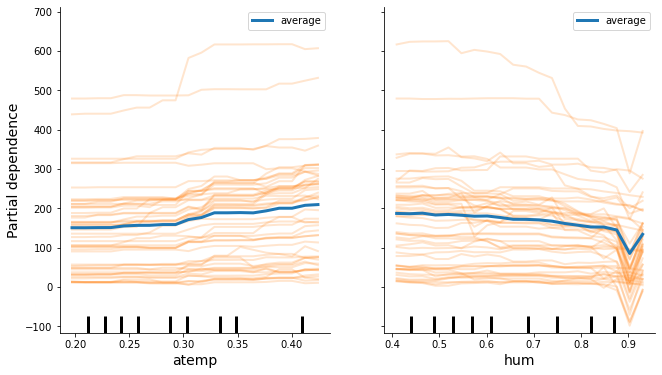

In [14]:
# Set features of interest
features = ['atemp', 'hum']

# Intialize figure to be used in plotting
fig, ax = plt.subplots(figsize=(16*2/3, 6))

# Generate partial dependence display plot
display = PartialDependenceDisplay.from_estimator(
    estimator=model,             # Estimator to be used
    X=test_predictors,           # Data to be used for interpretation
    features=features,           # Feature list to be inspected
    feature_names=feature_names, # Feature names in the data
    kind="both",                 # kind='average' refers to PDP
    n_jobs=3,                    # Number of CPU to compute the PDP in parallel
    grid_resolution=20,          # Number of points to be used in setting the
                                 #     feature of interest
    random_state=1337,           # Set random state for reproducibility
    subsample=50,                # Number of subsample ICE to plot
    ice_lines_kw={               # Set the keyword arguments for the format of
        'color': 'tab:orange',   #     the ICE lines. Here, we set the color of
        'alpha': 0.20,           #     the lines to be orange, 0.20 opacity,
        'linewidth': 2,          #     and line width of 2 pts.
    },
    ax=ax,
)

The orange lines in this plot refers to the ICE plot of each instance. Note that we only take a subsample of all of the instances in our test dataset. However, it is apparent that there are some instances that deviates greatly with the mean. For example, For ICEs with high bike counts, the effect of temperature and humidity is more pronounced.

### Advantages and Disadvantages

#### Advantage

The advantage of ICE plots is clear, PDP can be limited since it only shows us the average. If we want to **investigate a particular instance**, ICE is more useful. For example, in the bike sharing dataset, studying instances with high bike counts might be more useful than studying low bike counts. This helps us in uncovering **heterogeneous relationships** within our data.

#### Disadvantage

When using ICE curves, we can **only display one feature** at a time, since two features requires overlapping several surfaces which might be challenging to visualize.

ICE plots also have the same assumption with PDP: features of interest **must not be correlated** with other features. In this sense, if some degree of correlation is present in our data, some points in the ICE plot may be invalid data points.

## Permutation Importance

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature’s values, which breaks the relationship between the feature and the true outcome.

### Theory

The concept is really straightforward: We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. 

A feature is **"important"** if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. 

A feature is **"unimportant"** if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 

The permutation feature importance measurement was introduced by [Breiman (2001)](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) for random forests. Based on this idea, [Fisher, Rudin, and Dominici (2018)](https://arxiv.org/pdf/1801.01489.pdf) proposed a model-agnostic version of the feature importance and called it model reliance. They also introduced more advanced ideas about feature importance, for example a (model-specific) version that takes into account that many prediction models may predict the data well. Their paper is worth reading.


<img title="Model Reliance Paper" alt="Alt text" src="images/Permutation.png" width=500>

<b><center>
Model Reliance by Fisher, Rudin, and Dominici (2018)</center></b>

Ideally, random reordering of a column ought to result in reduced accuracy, since the new data has little or no correlation with real-world statistics. Model accuracy suffers most when an important feature, that the model was quite dependent on, is shuffled. With this insight, the process is as follows:

Get a trained model.
1. Shuffle the values for a single attribute and use this data to get new predictions. Next, evaluate change in loss function using these new values and predictions, to determine the effect of shuffling. The drop in performance  quantifies the importance of the feature that has been shuffled.
2. Reverse the shuffling done in the previous step to get the original data back.  
3. Redo step 2 using the next attribute, until the importance for every feature is determined.

### Implementation

Python’s ELI5 library provides a convenient way to calculate Permutation Importance. It works in Python 2.7 and Python 3.4+. Currently it requires scikit-learn 0.18+. You can install ELI5 using pip.

For this demonstration we will again use the Boston house prices dataset. For a brief description, see the text below:

In [15]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_boston
  
boston = load_boston()
print(boston.DESCR[20:1420])


Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by

#### Data Preparation and Model Fitting

In [16]:
from sklearn.model_selection import train_test_split

# separate data into target & independent variables
x = boston.data
y = boston.target

# split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, random_state=100)

print('Size of: ')
print('Training Set x: ', x_train.shape)
print('Training Set y: ', y_train.shape)
print('Test Set x: ', x_test.shape)
print('Test Set y: ', y_test.shape)

Size of: 
Training Set x:  (404, 13)
Training Set y:  (404,)
Test Set x:  (102, 13)
Test Set y:  (102,)


In [17]:
from sklearn.ensemble import RandomForestRegressor
  
# train model on training set
model = RandomForestRegressor()
  
# fit model on training set
model.fit(x_train, y_train)
  
# calculate score on test set
print('R2 score for test set: ')
print(model.score(x_test, y_test))

R2 score for test set: 
0.8893043253969799


In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error

rmse_full_mod = mean_squared_error(
    model.predict(x_test), y_test, squared=False)

In [19]:
# transform array to dataframe
X_test_df = pd.DataFrame(x_test)

# specify column names
X_test_df.columns = boston.feature_names

X_test_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.03768,80.0,1.52,0.0,0.404,7.274,38.3,7.3090,2.0,329.0,12.6,392.20,6.62
1,0.44178,0.0,6.20,0.0,0.504,6.552,21.4,3.3751,8.0,307.0,17.4,380.34,3.76
2,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
3,1.35472,0.0,8.14,0.0,0.538,6.072,100.0,4.1750,4.0,307.0,21.0,376.73,13.04
4,0.25356,0.0,9.90,0.0,0.544,5.705,77.7,3.9450,4.0,304.0,18.4,396.42,11.50


#### Permutation Importance Coded from Scratch

In [20]:
# initialize a list of results
results = []

# iterate through each predictor/column/feature
for predictor in X_test_df:

    # Create a copy of X_test
    X_test_copy = X_test_df.copy()

    # scramble the values of the given predictor
    X_test_copy[predictor] = X_test_df[predictor].sample(
        frac=1, random_state=100).values

    # calculate the new RMSE
    new_rmse = mean_squared_error(model.predict(X_test_copy), y_test,
                                  squared=False)

    # append the increase in MSE to the list of results
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod})

# convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by='score',
                                              ascending=False)

In [21]:
resultsdf

,pred,score
5,RM,4.983728
12,LSTAT,4.048536
7,DIS,0.992055
0,CRIM,0.556352
10,PTRATIO,0.398481
4,NOX,0.216307
9,TAX,0.173092
11,B,0.139049
6,AGE,0.138491
2,INDUS,0.082974


#### Using the eli5 library

In [22]:
import eli5
from eli5.sklearn import PermutationImportance
  
# create permutation importance object using model
# and fit on test set
perm = PermutationImportance(model, random_state=100).fit(x_test, y_test)
  
# display weights using PermutationImportance object
eli5.show_weights(perm, feature_names = boston.feature_names)

Weight,Feature
0.5551 ± 0.2657,LSTAT
0.5054 ± 0.0690,RM
0.0489 ± 0.0307,DIS
0.0378 ± 0.0207,CRIM
0.0227 ± 0.0156,PTRATIO
0.0201 ± 0.0026,NOX
0.0140 ± 0.0087,TAX
0.0137 ± 0.0059,B
0.0031 ± 0.0022,INDUS
0.0022 ± 0.0076,AGE


The values at the top of the table are the most important features in our model, while those at the bottom matter least.

The first number in each row indicates how much model performance decreased with random shuffling, using the same performance metric as the model (in this case, R2 score).

The number after the ± measures how performance varied from one-reshuffling to the next, i.e., degree of randomness across multiple shuffles.

Negative values for permutation importance indicate that the predictions on the shuffled (or noisy) data are more accurate than the real data. This means that the feature does not contribute much to predictions (importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets.

In our example, the top 3 features are LSTAT, RM and DIS, while the 3 least significant are AGE, CHAS and ZN.

### Advantages and Disadvantages

#### Advantages

Feature importance has a very **intuitive interpretation**: it is the increase in model error when the feature's inforamtion is destroyed. It provides a **highly compressed** and **global insight** into the model's behavior.

Furthermore, since we permute the feautre, we also destroy the interaction effects with other features. As such this importance measure **automatically takes into account all interactions** with other features.

Finally, permutation importance does not require model retraining.

#### Disadvantages

It can be **ambiguous** as to whether you should use the training or test data.

The interpretation is linked on the error of the model rather than the model output. There might be some cases wherein you would prefer to see how the feature values affect the model output.

Finally, since the permutation requires shuffling the feature. The results might vary depending on the random seed.

## LIME

[Local Interpretable Model-agnostic Explanations (LIME)](http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) is a Python project developed by Ribeiro et al. to interpret the predictions of any supervised Machine Learning (ML) model.

<img title="LIME Paper" alt="Alt text" src="images/LIME_paper.png" width="550">
<b><center>
Local Interpretable Model-agnostic Explanations (LIME) Paper  by Ribeiro et al.
</center></b>

Local explanations are based directly on a single observation. Using local explanations, we attempt to understand why ƒ generated that particular prediction for that specific sample. For any given sample, local explanations typically answer the question: “Which features most influenced this specific prediction?”

### Intuition

<img title="LIME Paper" alt="Alt text" src="images/Lime.jfif" width=500>

<b><center>
Lime - the fruit. Photo by Jessica Lewis on Unsplash.
</center></b>

LIME attempts to **approximate the model’s mapping function** $ƒ(𝒙)$ by sampling instances (referred to as input perturbation). 

In layman terms, LIME generates a bunch of synthetic samples $𝒙’$ which are closely based on the original instance $𝒙$. LIME then passes $𝒙’$ to the original model $ƒ$ and records the respective prediction. This process enables LIME to determine how the different input fluctuations are influencing $ƒ$. At the end of the process, for a given sample $𝒙$, LIME would be able to approximate the prediction of ƒ by determining the individual influence of every feature. Therefore, LIME is able to explain a specific prediction by understanding which features had the most contribution to the prediction.

**Summary**

- 🍈 samples instances $𝒙’$
- 🍈 uses $𝒙’$ to generate a set of predictions $𝑦’$ using ƒ(𝒙)
- 🍈 compares the prediction’s proximity to the original prediction and weights them.
- 🍈 uses the weights to determine which features are the most influential to that individual prediction.

**Toy example to present intuition for LIME**

<img title="LIME Toy Explanation" alt="Alt text" src="images/LIME toy exp.png" width="500">
<b><center>Image taken from the LIME article. </center></b>

The black-box model’s complex decision function $f$(unknown to LIME) is represented by the blue/pink background, which cannot be approximated well by a linear model. The bold red cross is the instance being explained. LIME samples instances, gets predictions using $f$, and weighs them by the proximity to the instance being explained (represented here by size). *The dashed line is the learned explanation that is locally (but not globally) faithful.*


### Theory

As previously mentioned, the whole idea of LIME is to attempt to interpret $ƒ(𝒙)$. LIME achieves this through surrogate models. A surrogate model $g$ is any model which is used to interpret the results of another predictive algorithm. Typically, $g$ would be a much simpler and much more interpretable model (like a decision tree or a linear model). We can formally define the set of surrogate models as $G$, such that $g ∈ G$.


**But, how does LIME select which $g$ to use for interpreting the original model?**

There are two main deciding factors that are considered by LIME:

1. **Local Faithfulness**, denoted by $L(f, g, π)$ — also called **fidelity** function
2. **Complexity**, denoted by $Ω(g)$

#### What is Local Faithfulness?

Let's try to break this down into two parts.

**Local**

Local simply means that we are focusing on one specific prediction at a time rather than considering ƒ holistically.

**Faithfulness**

This is a measure of how accurately our selected $g$ is able to follow the original model $ƒ$. The closer the predictions of $g$ to those of $ƒ$, the more faithful $g$ is said to be of $ƒ$. We refer to the *closeness* of the two predictions as the proximity, which is mathematically defined as $π$.

#### What is Complexity?

The main motivation behind $g$ is to interpret $ƒ$. Therefore, $g$ must be interpretable. The simpler the $g$, the more interpretable it becomes.

Complexity is measured in different ways, depending on the type of model being evaluated. For instance, in decision trees, the complexity can be directly given by the depth of the tree (the deeper the tree, the more complex and the less interpretable). In linear models, complexity might be measure in the number of non-zero weights.

#### LIME attempts to minimize complexity and maximize faithfulness.

 <center>$\xi(x) = \underset{g\in G}{argmin}$ $L(f, g, π) + Ω(g)$</center>
 
The fidelity function $L(f, g, π)$ can be defined by any loss function. LIME uses a square loss distance function. The loss function also changes depending on the type of model to be interpreted (an image classifier will require a different loss function than a tabular one). 

Now, let’s get our hands dirty with a Python example!

### Implementation

In [23]:
# imports
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# import lime
import lime
from lime.lime_tabular import LimeTabularExplainer

In [24]:
# load iris dataset
iris = load_iris()

print (iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [25]:
# specify random seed for reproducibility
np.random.seed(1)

# train - test split
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, train_size=0.8, random_state = 100)

# specify model, we use a random forest classifier
model = RandomForestClassifier()

# fit the model
model.fit(X_train, y_train)

# predict
predictions = model.predict(X_test)

# print Accuracy
print(f'Accuracy: {np.round((accuracy_score(y_test, predictions) * 100), 3)}%')

Accuracy: 96.667%


Next, we need to generate our LIME explainer function. Here we need to specify the training data, feature names, class labels, and whether to discretize continuous variables or not.

In [26]:
explainer = LimeTabularExplainer(X_train, 
                                 feature_names=iris.feature_names, 
                                 class_names=iris.target_names, 
                                 discretize_continuous=True)

Now we can generate an explanation for any prediction we want. At this step, we get to control the number of most influential features to show. This can be any integer value between 1 and the number of features in the dataset.

In [27]:
# pick first instance in the test dataset
i = 0
exp = explainer.explain_instance(
    X_test[i], 
    model.predict_proba, 
    num_features=2, 
    top_labels=1)

exp.show_in_notebook()

The model is 100% confident that instance 1 is virginica. 

To the left-hand side of the visualization, we get the predictive probability distribution per class. 

On the right-hand side, we get the top 2 (we specified this when we initialized the explainer function above) most influential features for that prediction along with their respective value. 

In the center of the plot, we get a condition per influential feature (based on the perturbed inputs) and its strength (i.e. contribution/influence to the model).

For example, the model predicted the sample to be a virginica with 100% confidence. 44% of this score was because the petal length is greater than 5.10cm and another 41% influence was added because of the petal width being greater than 1.8cm.

<div class="alert alert-info">

**Note**
    
The percentage of the scores could change as the ```explain_instance()``` method for tabular data does not have a set-up for random seed.
</div>

## References

<a name='ref:sklearn-pdp'></a> [1] scikit-learn developers, "Partial Dependence and Individual Conditional Expectation plots." *scikit-learn documentation*, 2021. https://scikit-learn.org/stable/modules/partial_dependence.html#individual-conditional-expectation-ice-plot

<a name='ref:molnar'></a> [2] Molnar, Christoph. “Interpretable machine learning. A Guide for Making Black Box Models Explainable”, 2019. https://christophm.github.io/interpretable-ml-book/.

[3] https://www.geeksforgeeks.org/machine-learning-explainability-using-permutation-importance/

[4] https://towardsdatascience.com/from-scratch-permutation-feature-importance-for-ml-interpretability-b60f7d5d1fe9

[5] https://towardsdatascience.com/understanding-lime-f94dab852617